In [46]:
import os
import torch

import matplotlib.pyplot as plt


pemp_losses = {}
pemp1_losses = {}
cnmp_losses = {}

num_samples = 250_000

for i in range(1, 5):
    folders = f'../outputs/comparison/{i}_peak/no_pos/8_2_64_64/bs_1/'
    l, l1, lcnmp = [], [], []
    for folder in os.listdir(folders):
        folder_path = os.path.join(folders, folder)

        tl = torch.tensor(torch.load(f'{folder_path}/losses.pt'))
        tl1 = torch.tensor(torch.load(f'{folder_path}/losses1.pt'))
        tlcnmp = torch.tensor(torch.load(f'{folder_path}/losses_cnmp.pt'))

        tl_ids = (torch.linspace(0, len(tl)-1, num_samples)).long()
        tl1_ids = (torch.linspace(0, len(tl1)-1, num_samples)).long()
        tlcnmp_ids = (torch.linspace(0, len(tlcnmp)-1, num_samples)).long()

        l.append(tl[tl_ids])
        l1.append(tl1[tl1_ids])
        lcnmp.append(tlcnmp[tlcnmp_ids])
        
    pemp_losses[i] = torch.mean(torch.stack(l), dim=0)
    pemp1_losses[i] = torch.mean(torch.stack(l1), dim=0)
    cnmp_losses[i] = torch.mean(torch.stack(lcnmp), dim=0)


In [47]:
def moving_avg(tl, window_size=100):
    weights = torch.full((window_size,), 1.0 / window_size, dtype=tl.dtype, device=tl.device)

    # convolution for sliding window
    t = torch.nn.functional.conv1d(
        tl.unsqueeze(0).unsqueeze(0),
        weights.unsqueeze(0).unsqueeze(0),
        padding='same'
    ).squeeze(0).squeeze(0)

    # first and last few elements
    t[:window_size // 2] = torch.cumsum(tl[:window_size // 2], dim=0) / torch.arange(1, window_size // 2 + 1, device=tl.device)
    t[-window_size // 2:] = torch.flip(torch.cumsum(torch.flip(tl[-window_size // 2:], dims=[0]), dim=0), dims=[0]) / torch.arange(window_size // 2, 0, -1, device=tl.device)

    return t


filter_size = 1000
samples = 10000
for i in range(1, 5):
    l0 = moving_avg(pemp_losses[i], filter_size)
    l1 = moving_avg(pemp1_losses[i], filter_size)
    l2 = moving_avg(cnmp_losses[i], filter_size)

    pemp_losses[i] = l0[torch.linspace(0, len(l0)-1, samples).long()]
    pemp1_losses[i] = l1[torch.linspace(0, len(l0)-1, samples).long()]
    cnmp_losses[i] = l2[torch.linspace(0, len(l0)-1, samples).long()]


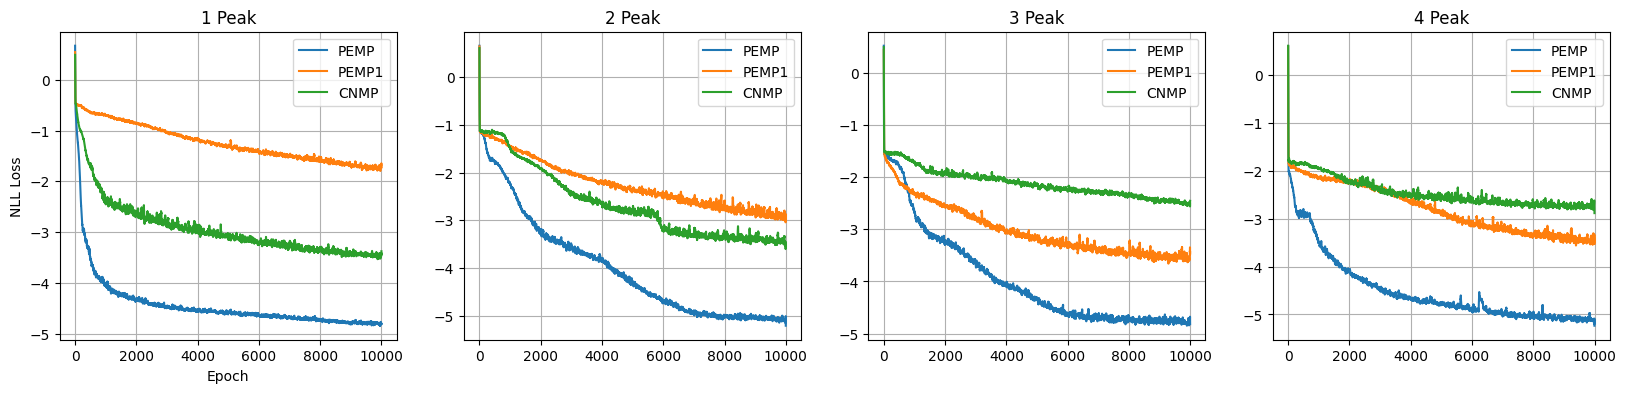

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

x = torch.arange(samples-1)

for i in range(1, 5):
    axs[i-1].plot(x, pemp_losses[i][:-1].numpy(), label=f'PEMP')
    axs[i-1].plot(x, pemp1_losses[i][:-1].numpy(), label=f'PEMP1')
    axs[i-1].plot(x, cnmp_losses[i][:-1].numpy(), label=f'CNMP')

    axs[i-1].legend()
    axs[i-1].set_title(f'{i} Peak')
    axs[i-1].set_xlabel('Epoch')
    axs[i-1].set_ylabel('NLL Loss')
    axs[i-1].grid()

plt.show()